In [1]:
import os
from google.cloud import vision
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.transform import rotate, resize, rescale
import ultralytics
from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor
ultralytics.checks()

# Our scripts
from Python_Helpers.image_loading import * 
from Python_Helpers.preprocessing import * 
from Python_Helpers.corrections import *
from Python_Helpers.ID_isolation import *
from Python_Helpers.YOLO import *

# YOLO stuff.
relevant_characters = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y', 21:''}
letter_model = YOLO('../YOLO_Data/YOLOletters.pt')
number_model = YOLO('../YOLO_Data/YOLOnumbers.pt')

# Google cloud tocken and files
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"guppies-test-4c48569421d8.json"
google_file_list = ListGoogleFiles('guppy_images', prefix='Manually_Labelled/New', verbose=True)
random.shuffle(google_file_list)

# # Dropbox authentication and files
# import dropbox
# DROPBOX_ACCESS_TOKEN = 'sl.Bne0Se2BcQKu1Bw_HIMACqND8FQgKnAN0FJSA13Hf04pkVVYn5_9HMH6a-9A61u692gBHjsax340Ohd1fTtFszYFy0tAFCuSCjsyyY9_V0SJz3Fydgs-lWmGHq3ZcQWPsrBdD5FkMdI1BsRxOndsd2w'
# dbx = dropbox.Dropbox(DROPBOX_ACCESS_TOKEN)
# dropbox_file_list = ListDropBoxFiles(dbx, 'Guppy_Images', prefix='', verbose=True)

Ultralytics YOLOv8.0.196  Python-3.11.5 torch-2.1.0+cpu CPU (AMD Ryzen 7 PRO 4750U with Radeon Graphics)
Setup complete  (16 CPUs, 21.7 GB RAM, 165.2/237.7 GB disk)



Files have been read from Google.


In [5]:
# Runs an image file through the whole code and outputs two predictions (google and YOLO) along with the initial and ID images.
def MainFunction(image_in_bytes, padx=80, pady=20, delta_width=10, probability_threshold=0.5, verbose=False):
    # Initial google read and preprocessing of image.
    decoded = np.frombuffer(image_in_bytes.getvalue(), dtype=np.uint8)
    initial_image = cv2.imdecode(decoded, cv2.IMREAD_COLOR)

    if verbose: plt.imshow(initial_image)

    Initial_Results = GoogleRead(image_in_bytes, verbose=verbose)
    Processed_Results, title, ID, date = PreprocessLabel(Initial_Results, verbose=verbose)

    # Corrected google prediction.
    title, ID, date = CorrectOutput(title, ID, date)

    # Identity isolation and YOLO ID results
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, verbose=verbose)
    characters, boxes, probs, letter_idx, processed_ID_image = UseYOLO(letter_model, number_model, ID_Dictionary['frame'], probability_threshold=probability_threshold, verbose=verbose)

    if verbose:
        print('\nGoogle prediction:', '-'.join([title, ID, date]))
        print('YOLO prediction:', '-'.join([title, ''.join(characters), date]))

        plt.imshow(ID_Dictionary['frame'])

    return '-'.join([title, ID, date]), '-'.join([title, ''.join(characters), date]), initial_image, ID_Dictionary['frame'], processed_ID_image


def extract_ID(file_name):
    #extract the ID from the filename.
    f = file_name.split('/')[-1].split('.')[0]
        
    if 's' in f:
        f = f.split('s')[0]

    if '(' in f: #this is something where the file has a (1) in it.
        f = f.split('(')[0][:-1]
            
    title = f[:3]
    date = f[-4:]
    id = f[3:-4]

    return title, id, date


image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 W, 105.4ms
Speed: 0.0ms preprocess, 105.4ms inference, 15.9ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 77.6ms
Speed: 0.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


[    0.87462      0.9013     0.65804]


#######################
Google Prediction: MCA-3G5W-08/24/11
YOLO Prediction: MCA-35W-08/24/11
#######################


Text(0.5, 1.0, 'Final ID')

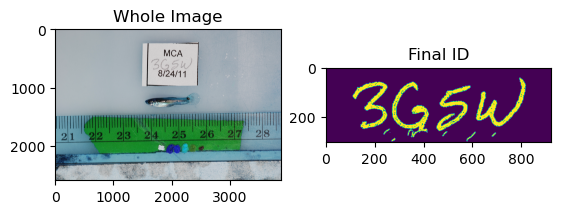

In [7]:
# Load from google
file_name = random.choice(google_file_list)
image_in_bytes = RetreiveImageGoogle('guppy_images', file_name)

# # Load from Dropbox
# file_name = random.choice(dropbox_file_list)
# image_in_bytes = RetreiveImageDropBox(dbx, file_name)

# # Load from local file
# file_name = r"C:\Users\newc6448\Projects\Guppies\FCA1B4W1212.JPG"
# image_in_bytes = RetreiveImageLocal(file_name)

Google_Prediction, YOLO_Prediction, initial_image, ID_image, processed_ID_image = MainFunction(image_in_bytes, probability_threshold=0.3, verbose=False)

print('\n\n#######################')
print('Google Prediction:', Google_Prediction)
print('YOLO Prediction:', YOLO_Prediction)
print('#######################')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(initial_image)
ax2.imshow(ID_image)

ax1.set_title('Whole Image')
ax2.set_title('Final ID')

In [41]:
google_attempted = 0
yolo_attempted = 0

both = 0
google = 0
yolo = 0
wrong = 0
invalid = 0

total = 0

random.shuffle(google_file_list)
for i, file in enumerate(google_file_list[:100]):
    total += 1
    try:
        correctTitle, correctID, correctDate = extract_ID(file)
        image_in_bytes = RetreiveImageGoogle('guppy_images', file)
        Google_Prediction, YOLO_Prediction, initial_image, ID_image, processed_ID_image = MainFunction(image_in_bytes, probability_threshold=0.5, verbose=False)
        Google_Title_Prediction, Google_ID_Prediction, Google_Date_Prediction = Google_Prediction.split('-')
        YOLO_Title_Prediction, YOLO_ID_Prediction, YOLO_Date_Prediction = YOLO_Prediction.split('-')

        print([correctTitle, correctID], [Google_Title_Prediction, Google_ID_Prediction], [YOLO_Title_Prediction, YOLO_ID_Prediction])

        if len(Google_ID_Prediction) >= 4 and (len(Google_ID_Prediction) % 2) == 0:
            google_attempted += 1

        if len(YOLO_ID_Prediction) >= 4 and (len(YOLO_ID_Prediction) % 2) == 0:
            yolo_attempted += 1

        if Google_Title_Prediction == correctTitle and Google_ID_Prediction == correctID and YOLO_ID_Prediction == correctID and YOLO_Title_Prediction == correctTitle:
            both += 1
            print('Both')
        elif Google_Title_Prediction == correctTitle and Google_ID_Prediction == correctID:
            google += 1
            print('Google')
        elif YOLO_ID_Prediction == correctID and YOLO_Title_Prediction == correctTitle:
            yolo += 1
            print('YOLO')
        else: 
            wrong += 1
            print('None')

    except: 
        invalid += 1


image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 W, 67.8ms
Speed: 1.0ms preprocess, 67.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 3s, 1 7, 66.7ms
Speed: 0.5ms preprocess, 66.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '3V7W'] ['FLL', '3V7W'] ['FLL', '37W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 F, 137.0ms
Speed: 1.6ms preprocess, 137.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 3, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '2F3B'] ['MUL', '2F3B'] ['MUL', '2F3B']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 P, 93.2ms
Speed: 1.0ms preprocess, 93.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 4, 1 8, 67.4ms
Speed: 1.0ms preprocess, 67.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '4P8G'] ['FLL', '4P8G'] ['FLL', '81']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Ws, 2 Ys, 102.2ms
Speed: 4.0ms preprocess, 102.2ms inference, 3.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 88.6ms
Speed: 0.0ms preprocess, 88.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '3F5W'] ['MUL', '3/5Y'] ['MUL', '35W']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 2 8s, 76.5ms
Speed: 0.0ms preprocess, 76.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '2S8O'] ['FTY', '2S8O'] ['FTY', '28']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 R, 1 W, 100.7ms
Speed: 0.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 7, 1 8, 78.2ms
Speed: 1.0ms preprocess, 78.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '7N8R'] ['FUL', '7N3R'] ['FUL', 'WB']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 O, 1 R, 43.2ms
Speed: 1.0ms preprocess, 43.2ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 5, 32.7ms
Speed: 1.5ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '4O5R'] ['MLL', '4O5R'] ['MLL', 'O5R']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 O, 1 V, 99.1ms
Speed: 1.1ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 5, 1 6, 72.5ms
Speed: 0.5ms preprocess, 72.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '5V6O'] ['FLL', '5V6O'] ['FLL', '5V6O']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Bs, 106.2ms
Speed: 0.0ms preprocess, 106.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 8, 74.5ms
Speed: 1.0ms preprocess, 74.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '1N8O'] ['MUL', '1N8O'] ['MUL', '8']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 N, 38.1ms
Speed: 1.0ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 5, 30.2ms
Speed: 1.0ms preprocess, 30.2ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['DSC', '_'] ['FUL', '1N5B'] ['FUL', 'N5']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 R, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 3 4s, 79.6ms
Speed: 1.0ms preprocess, 79.6ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '1B4R'] ['MUL', '1B4R'] ['MUL', '1B4']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 100.7ms
Speed: 1.0ms preprocess, 100.7ms inference, 2.6ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 77.2ms
Speed: 1.0ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '1F4K'] ['FUL', '1F4K'] ['FUL', '']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 92.6ms
Speed: 1.0ms preprocess, 92.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 71.3ms
Speed: 1.0ms preprocess, 71.3ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '3G7O'] ['MTY', '3G7O'] ['MTY', 'G']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 118.0ms
Speed: 1.0ms preprocess, 118.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 5, 73.9ms
Speed: 1.0ms preprocess, 73.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '2F5R'] ['FUL', '2F5R'] ['FUL', '5']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 S, 94.7ms
Speed: 1.0ms preprocess, 94.7ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 2, 74.7ms
Speed: 1.0ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '1G2F'] ['MUL', '1G2F'] ['MUL', '1G2']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 R, 1 Y, 100.7ms
Speed: 1.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 7, 78.9ms
Speed: 1.0ms preprocess, 78.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '4R7W'] ['FTY', '4RW'] ['FTY', '1R7']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 O, 1 P, 89.1ms
Speed: 0.9ms preprocess, 89.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 86.5ms
Speed: 0.0ms preprocess, 86.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '3K6V'] ['FLL', '3K6V'] ['FLL', '']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 4 Ps, 81.8ms
Speed: 1.6ms preprocess, 81.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 5, 69.8ms
Speed: 1.6ms preprocess, 69.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '4B5B'] ['MLL', '4B5B'] ['MLL', 'B5P']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 N, 1 P, 1 W, 107.7ms
Speed: 1.0ms preprocess, 107.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 7, 74.5ms
Speed: 1.0ms preprocess, 74.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '2N7F'] ['FUL', '2N7F'] ['FUL', '2N7']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 68.8ms
Speed: 0.0ms preprocess, 68.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 1 2, 47.3ms
Speed: 0.0ms preprocess, 47.3ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '2P4F'] ['FLL', '2P4F'] ['FLL', '']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Gs, 1 R, 63.8ms
Speed: 0.0ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 4, 1 6, 64.0ms
Speed: 0.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '4K6R'] ['FUL', '4K6R'] ['FUL', '46R']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 R, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 1s, 1 8, 53.5ms
Speed: 1.0ms preprocess, 53.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '4F8R'] ['FLL', '4F8R'] ['FLL', '8']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 N, 1 P, 1 W, 76.5ms
Speed: 0.0ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 3 1s, 1 8, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '1V8Y'] ['MTY', '1V8Y'] ['MTY', '18']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 3 Ps, 1 S, 1 W, 66.0ms
Speed: 1.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '3V5R'] ['FLL', '3V5R'] ['FLL', '35']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 6, 1 7, 65.4ms
Speed: 1.5ms preprocess, 65.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '6G7F'] ['FUL', '6G7F'] ['FUL', '6G']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 1 R, 2 Ws, 68.0ms
Speed: 1.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 2 7s, 57.6ms
Speed: 1.0ms preprocess, 57.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '2W7P'] ['MLL', '2W7P'] ['MLL', 'RW']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 R, 1 W, 79.6ms
Speed: 1.0ms preprocess, 79.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 5, 1 6, 63.6ms
Speed: 1.0ms preprocess, 63.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '5R6W'] ['FLL', '5R6W'] ['FLL', '5R6W']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 2 Ps, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 4, 1 5, 59.6ms
Speed: 0.0ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '4G5K'] ['MTY', '4G5K'] ['MTY', '4G5P']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 1 V, 67.0ms
Speed: 1.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 1 3, 2 7s, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '3V7B'] ['FUL', '3Y7O'] ['FUL', '3V7P']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 71.0ms
Speed: 1.0ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 6, 54.0ms
Speed: 0.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '1S6G'] ['FTY', '1S6G'] ['FTY', '6']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 O, 1 P, 62.6ms
Speed: 1.0ms preprocess, 62.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 1 5, 54.5ms
Speed: 0.0ms preprocess, 54.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '4K5O'] ['MLL', '4K5O'] ['MLL', '5']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 V, 1 W, 69.5ms
Speed: 1.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 7, 66.6ms
Speed: 1.0ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '2B7V'] ['MUL', '2B7V'] ['MUL', '2B7']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 101.5ms
Speed: 9.0ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 6, 47.6ms
Speed: 1.0ms preprocess, 47.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '1W2B'] ['MLL', '1W2B'] ['MLL', '6']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 F, 1 G, 65.9ms
Speed: 1.0ms preprocess, 65.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 6, 1 7, 47.8ms
Speed: 1.0ms preprocess, 47.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '1F6O7F'] ['FLL', '1F6O1F'] ['FLL', '6F']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 Y, 96.6ms
Speed: 7.0ms preprocess, 96.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 6, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '4B6Y'] ['MLL', '4B6Y'] ['MLL', '1B6Y']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Ps, 79.6ms
Speed: 1.0ms preprocess, 79.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 7, 71.0ms
Speed: 1.0ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '5O7K'] ['FUL', '5O7K'] ['FUL', '']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 W, 69.6ms
Speed: 0.0ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 5, 1 7, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '2O5N'] ['FUL', '2O5N'] ['FUL', '2B5W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 89.0ms
Speed: 0.0ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 2, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '1F2R'] ['MUL', '1F2R'] ['MUL', '2']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 P, 87.8ms
Speed: 0.0ms preprocess, 87.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 1 1, 3 7s, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '1O7K'] ['FUL', '1O7K'] ['FUL', 'B07']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 O, 2 Ws, 65.9ms
Speed: 1.0ms preprocess, 65.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 2, 1 8, 49.5ms
Speed: 1.0ms preprocess, 49.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '2W8W'] ['MLL', '2W8W'] ['MLL', '2W8']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 1 W, 83.5ms
Speed: 1.0ms preprocess, 83.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 8, 59.1ms
Speed: 1.4ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FCA', '1O8W'] ['FCA', '1O8W'] ['FCA', '18']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 K, 1 O, 1 P, 61.0ms
Speed: 0.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 6, 52.6ms
Speed: 0.0ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '3K6G'] ['MLL', '3K6G'] ['MLL', '3K6G']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 54.8ms
Speed: 0.0ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 8, 42.0ms
Speed: 0.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '4R8F'] ['FLL', '4R8F'] ['FLL', '8']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 O, 87.5ms
Speed: 4.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 1 6, 3 7s, 53.6ms
Speed: 1.0ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '6O7G'] ['MLL', '6O7G7'] ['MLL', '07']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 F, 1 G, 1 P, 63.0ms
Speed: 0.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 7, 1 8, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '6G7B'] ['FUL', '6G7B'] ['FUL', 'GP']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 V, 1 W, 75.6ms
Speed: 0.0ms preprocess, 75.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 6, 1 8, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '6V8W'] ['FUL', '6V8W'] ['FUL', '6W8']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 W, 69.6ms
Speed: 0.0ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 6, 52.5ms
Speed: 1.0ms preprocess, 52.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FCA', '4G6P'] ['FCA', '4G6P'] ['FCA', 'G6']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 R, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 6, 61.5ms
Speed: 0.0ms preprocess, 61.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '1R6Y'] ['MLL', '1R6Y'] ['MLL', '16']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 51.5ms
Speed: 1.0ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 4, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '3V4B'] ['MTY', '3V4B'] ['MTY', '34']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 2 Ws, 86.5ms
Speed: 0.0ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 6, 1 8, 62.5ms
Speed: 1.0ms preprocess, 62.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FCA', '4W6P'] ['FCA', '4W6FP'] ['FCA', 'WW']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 65.5ms
Speed: 0.0ms preprocess, 65.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 4, 1 7, 52.0ms
Speed: 0.0ms preprocess, 52.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '4K7Y'] ['MLL', '4K7Y'] ['MLL', '7']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Bs, 1 R, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 5, 1 8, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '5P8V'] ['FLL', '5P8V'] ['FLL', '58']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Ps, 45.5ms
Speed: 1.0ms preprocess, 45.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 4, 36.4ms
Speed: 1.1ms preprocess, 36.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '3P4P'] ['MUL', '3P4P'] ['MUL', '3P4P']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 O, 1 R, 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '3O5R'] ['MUL', '3O5R'] ['MUL', '3O5R']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 3 Gs, 1 W, 36.7ms
Speed: 0.0ms preprocess, 36.7ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 6, 120.4ms
Speed: 8.0ms preprocess, 120.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '2W6G'] ['MTY', '2W6G'] ['MTY', '2W6G']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 33.6ms
Speed: 1.0ms preprocess, 33.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 5, 34.0ms
Speed: 0.0ms preprocess, 34.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '4G5V'] ['FUL', '4H6SV'] ['FUL', 'G5']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 O, 70.6ms
Speed: 1.0ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 7, 70.6ms
Speed: 0.0ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '3G7O'] ['MLL', '3G7O'] ['MLL', '3G7O']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 R, 70.2ms
Speed: 1.0ms preprocess, 70.2ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 8, 43.6ms
Speed: 1.0ms preprocess, 43.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '6R8O'] ['MLL', '6R8O'] ['MLL', '8']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 N, 1 O, 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 8, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '3V8O'] ['FTY', '3K8O'] ['FTY', '38']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 67.6ms
Speed: 1.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 5, 2 6s, 71.0ms
Speed: 1.0ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '4K5Y6Y'] ['FLL', '4K5Y69'] ['FLL', '56']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 F, 48.0ms
Speed: 1.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 47.5ms
Speed: 1.0ms preprocess, 47.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '1G4B'] ['MUL', '1G4B'] ['MUL', '1']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 K, 2 Ws, 72.9ms
Speed: 1.0ms preprocess, 72.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MLL', '3V5K'] ['MLL', '3V5K'] ['MLL', '3W5K']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Gs, 1 W, 72.6ms
Speed: 1.0ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 2, 1 6, 1 7, 54.0ms
Speed: 0.0ms preprocess, 54.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '2W6K'] ['FUL', '2W6'] ['FUL', 'WG']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 46.0ms
Speed: 0.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 44.6ms
Speed: 0.0ms preprocess, 44.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '1P2B'] ['FUL', '1P2B'] ['FUL', '2']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 2 Fs, 1 G, 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 3.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '6P7O'] ['FTY', '6P7O'] ['FTY', 'G']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 76.0ms
Speed: 1.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 7, 64.5ms
Speed: 2.5ms preprocess, 64.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '1V7F'] ['FLL', '1N7F'] ['FLL', '']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 F, 1 P, 1 R, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 6, 1 7, 48.5ms
Speed: 1.0ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MCA', '6R7P'] ['MCA', '6R7P'] ['MCA', '6R7P']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 79.2ms
Speed: 1.0ms preprocess, 79.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 5, 1 7, 57.0ms
Speed: 0.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '5Y7S'] ['MTY', '5Y7S'] ['MTY', '51']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 N, 70.6ms
Speed: 0.0ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 73.1ms
Speed: 1.0ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '3N5G'] ['MUL', '3N5G'] ['MUL', '35G']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Gs, 53.6ms
Speed: 0.0ms preprocess, 53.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 6, 50.5ms
Speed: 0.0ms preprocess, 50.5ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '2Y6G'] ['MUL', '2Y6G'] ['MUL', '26G']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Gs, 1 N, 3 Ws, 36.8ms
Speed: 1.0ms preprocess, 36.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 1s, 2 6s, 1 7, 90.5ms
Speed: 0.0ms preprocess, 90.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '6W7N'] ['MUL', '6W7N'] ['MUL', 'W7']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 W, 30.0ms
Speed: 1.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 2, 31.5ms
Speed: 1.0ms preprocess, 31.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '2W8P'] ['FTY', '2W8P'] ['FTY', '2W1B']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 1 S, 51.6ms
Speed: 0.0ms preprocess, 51.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 6, 1 7, 57.7ms
Speed: 1.0ms preprocess, 57.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '6S7G'] ['FUL', '6S7G'] ['FUL', '6S7G']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 G, 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 1s, 1 6, 31.9ms
Speed: 1.0ms preprocess, 31.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FCA', '1K6K'] ['FCA', '1K6K'] ['FCA', '6']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 P, 1 V, 1 Y, 62.5ms
Speed: 0.0ms preprocess, 62.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 5, 50.6ms
Speed: 1.0ms preprocess, 50.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '2S6K'] ['FTY', '2SK'] ['FTY', '2']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 62.0ms
Speed: 0.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 8, 55.0ms
Speed: 1.5ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '6F8K'] ['FUL', '6F8K'] ['FUL', 'B']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 G, 1 W, 62.4ms
Speed: 0.0ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 7, 1 8, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '7G8V'] ['MUL', '7G8V'] ['MUL', '7G8W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 K, 1 W, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 5, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 15.6ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '2N5K'] ['FTY', '2N5K'] ['FTY', '2W5K']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 W, 39.7ms
Speed: 1.0ms preprocess, 39.7ms inference, 3.3ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 2, 1 8, 40.2ms
Speed: 0.0ms preprocess, 40.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '2G8V'] ['MUL', '2G8V'] ['MUL', '28W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 2 Ps, 63.5ms
Speed: 0.0ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 5, 1 8, 31.6ms
Speed: 0.0ms preprocess, 31.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '5P8O'] ['FUL', '5P8O'] ['FUL', '5B']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 G, 1 P, 58.5ms
Speed: 0.0ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 4, 1 8, 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '3G4B8P'] ['FUL', '3G4B8P'] ['FUL', '3G4B8P']
Both



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 68.0ms
Speed: 1.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 4, 57.5ms
Speed: 1.0ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MTY', '3G4V'] ['MTY', '3G4V'] ['MTY', '34']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 F, 1 G, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 3, 1 7, 49.8ms
Speed: 0.0ms preprocess, 49.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '3G7F'] ['FLL', '3O1Y1'] ['FLL', '3G71B']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 W, 46.6ms
Speed: 0.0ms preprocess, 46.6ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 0, 1 5, 1 7, 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '5O7W'] ['FLL', '5O7W'] ['FLL', '5B7W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 F, 1 O, 82.0ms
Speed: 1.0ms preprocess, 82.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 7, 157.6ms
Speed: 1.5ms preprocess, 157.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '3O7Y'] ['FUL', '3O7Y'] ['FUL', '3O7']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Ps, 100.1ms
Speed: 2.2ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 3, 1 4, 1 6, 57.9ms
Speed: 0.0ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '3P4P6O'] ['MUL', '3O4F6O'] ['MUL', '3P4P6']
None



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 R, 1 W, 43.8ms
Speed: 0.0ms preprocess, 43.8ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 1s, 1 3, 53.1ms
Speed: 0.0ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['FLL', '1R3W'] ['FLL', '1R3W'] ['FLL', '13W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 F, 1 W, 48.2ms
Speed: 0.0ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 4, 1 7, 47.3ms
Speed: 0.0ms preprocess, 47.3ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '3W4F'] ['FUL', '3W4F'] ['FUL', '3W']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 B, 1 O, 1 S, 47.3ms
Speed: 0.0ms preprocess, 47.3ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 3, 1 5, 1 6, 46.9ms
Speed: 0.0ms preprocess, 46.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['FUL', '3O6S'] ['FUL', '3O6S'] ['FUL', '36']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 (no detections), 46.5ms
Speed: 1.0ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 1 1, 1 5, 45.9ms
Speed: 1.0ms preprocess, 45.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)


['MUL', '4N5S'] ['MUL', '4N5S'] ['MUL', '5']
Google



image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 Ps, 39.5ms
Speed: 0.0ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\jordanlee\Projects\Guppies\Temp_YOLO_File.jpg: 64x256 2 1s, 1 3, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)


['FTY', '1S7B'] ['FTY', '1S7F7B'] ['FTY', '1P']
None


In [42]:
print('#######################')
print('Total Files Read:', total)
print('\nGoogle % Attempted:', google_attempted / total, '(%i)' %google_attempted)
print('Google % Correct:', (both + google) / google_attempted)
print('\nYOLO % Atttempted:', yolo_attempted / total, '(%i)' %yolo_attempted)
print('YOLO % Correct:', yolo_attempted and (both + yolo) / yolo_attempted or 0)
print('#######################')

#######################
Total Files Read: 100

Google % Attempted: 0.84 (84)
Google % Correct: 0.8809523809523809

YOLO % Atttempted: 0.2 (20)
YOLO % Correct: 0.55
#######################


In [4]:
%%capture
# Can be used to check where errors are being raised and what is raising them.
exceptions = []

for i in range(10):  
    file_name = random.choice(google_file_list)
    image_in_bytes = RetreiveImageGoogle('guppy_images', file_name)

    file_name = random.choice(dropbox_file_list)
    image_in_bytes = RetreiveImageDropBox(dbx, file_name)
    try:
        Google_Prediction, YOLO_Prediction, initial_image, ID_image = MainFunction(image_in_bytes, verbose=False)
    except Exception as e: exceptions.append(e)

print(len(exceptions))
# print(exceptions)


image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 128x256 1 P, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 128x256 1 0, 1 8, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x256 1 B, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x256 1 3, 1 4, 30.0ms
Speed: 1.0ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x256 (no detections), 29.0ms
Speed: 1.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x

In [4]:
# Function returns just the ID image. Can be used to check the ID_isolation process.
def ImageFunction(image_in_bytes, padx=80, pady=20, delta_width=10, verbose=False):
    # Initial google read and preprocessing of image.
    Initial_Results = GoogleRead(image_in_bytes, verbose=verbose)
    Processed_Results = PreprocessLabel(Initial_Results, verbose=verbose)[0]

    # Identity isolation and YOLO ID results
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, verbose=verbose)

    return ID_Dictionary['frame']


# A function that can be ran in parallel which appends the images to a list.
def ParallelImageFunction(image_in_bytes):
    ID_image = ImageFunction(image_in_bytes)
    ID_images.append(ID_image)
    return


def ParallelInitialImages(file_name, source='google'):
    if source == 'google':
        image_in_bytes = RetreiveImageGoogle('guppy_images', file_name)

    if source == 'dropbox':
        image_in_bytes = RetreiveImageDropBox(dbx, file_name)

    if source == 'local':
        image_in_bytes = RetreiveImageLocal(file_name)

    initial_images.append(image_in_bytes)

In [5]:
random.shuffle(google_file_list)

files = google_file_list[:400]
initial_images = []
ID_images = []

with ThreadPoolExecutor() as executor:
    executor.map(ParallelInitialImages, files)

with ThreadPoolExecutor() as executor:
    executor.map(ParallelImageFunction, initial_images)

print(len(initial_images))
print(len(ID_images))

400
388


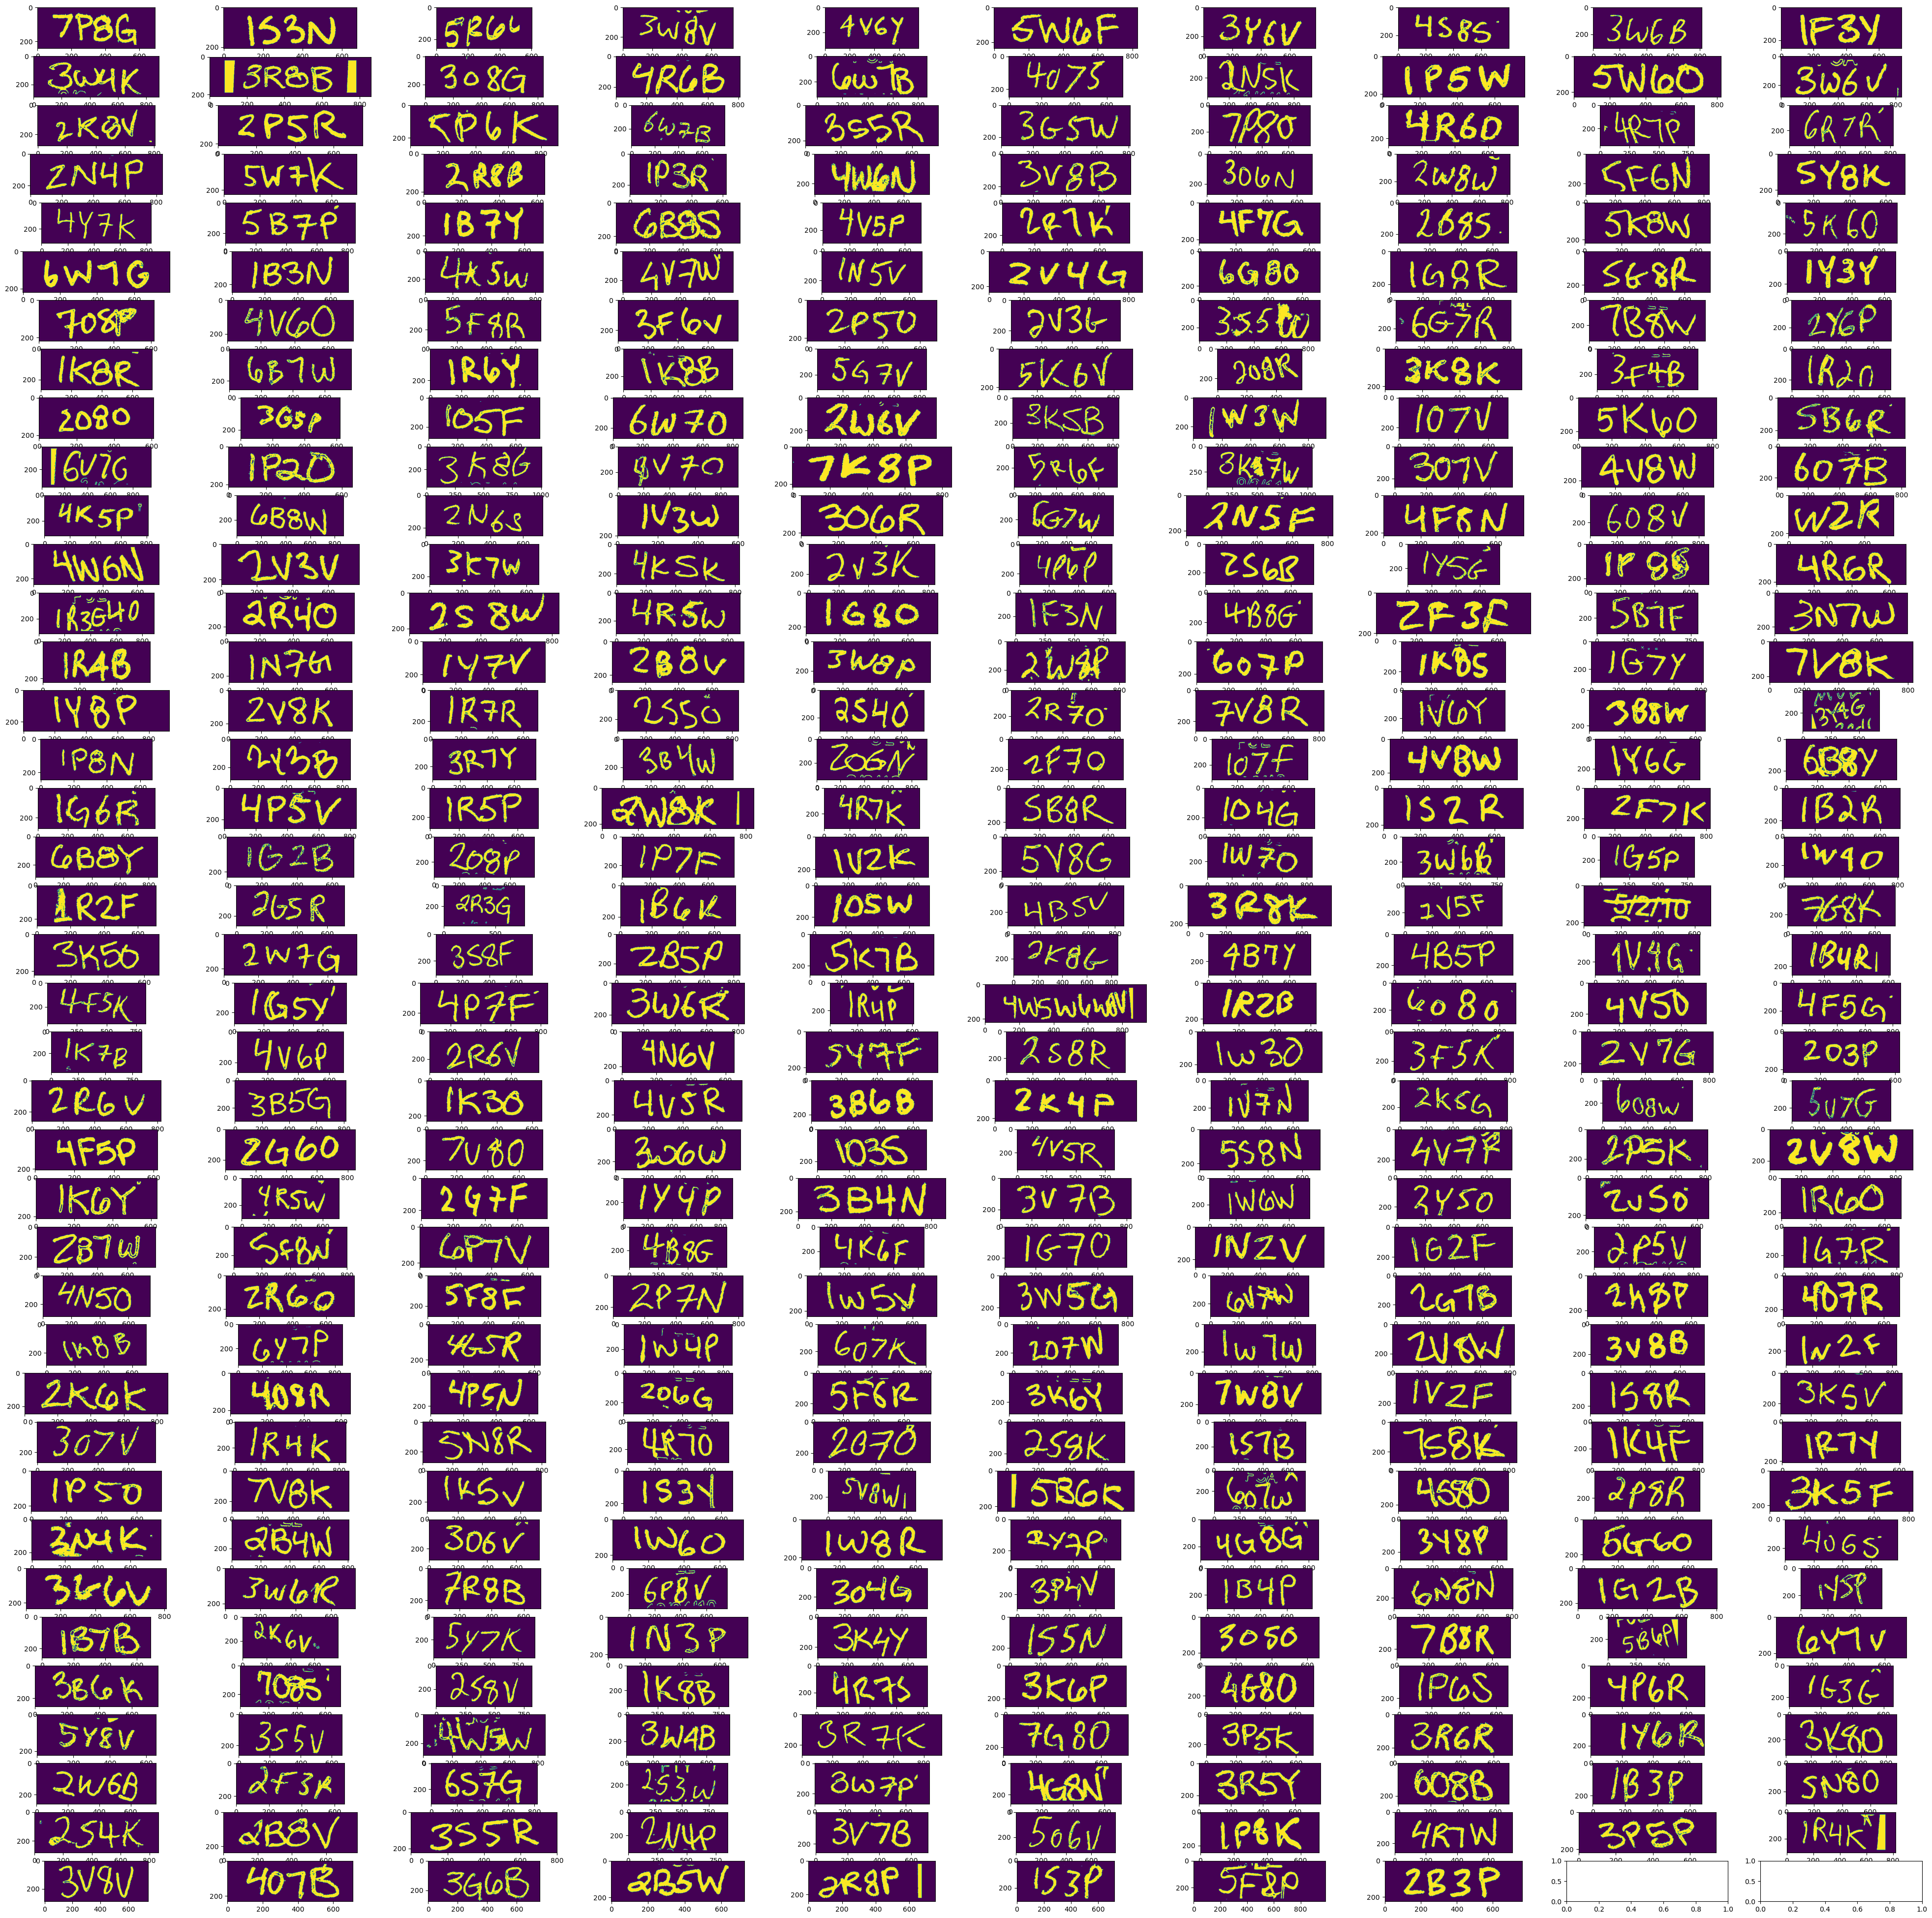

In [6]:
fig,ax = plt.subplots(39,10, figsize=(50,50))

for n, image in enumerate(ID_images):
    i, j = n//10, n%10
    ax[i,j].imshow(image)